# Tutorial 3: Running Inference Step by Step

This tutorial demonstrates how to run inference step-by-step, breaking down the `inference.run()` command into its constituent parts.

1. **Phase 1**: Pre-selection + Incoherent filtering (per bank, no threshold)
2. **Phase 2**: Global cut (find global max, apply threshold across all banks)
3. **Phase 3**: Extrinsic sample generation (using filtered intrinsic samples)
4. **Phase 4**: Coherent inference (per bank)
5. **Phase 5**: Post-processing and combination

In this tutorial we'll:

1. Create mock data and a small bank
2. Select intrinsic samples based on chirp mass
3. Demonstrate Phase 1 & 2: Incoherent filtering and global cut
4. Visualize selected samples vs. original bank
5. Demonstrate Phase 3: Draw extrinsic samples using filtered indices
6. Demonstrate Phase 4: Perform coherent likelihood evaluations
7. Demonstrate Phase 5: Standardize samples and create corner plots
8. Finally, show how to use `inference.run()` for a streamlined process


In [1]:
import sys

sys.path.append("../..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from cogwheel import data, gw_utils, gw_plotting, utils, prior_ratio
from cogwheel.gw_prior import IntrinsicIASPrior
from cogwheel.posterior import Posterior
from cogwheel.likelihood import RelativeBinningLikelihood
from dot_pe import inference, waveform_banks, config
from dot_pe.power_law_mass_prior import PowerLawIntrinsicIASPrior
from dot_pe.utils import load_intrinsic_samples_from_rundir

# Set up artifacts directory for all outputs
ARTIFACTS_DIR = Path("./artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

## Step 1: Create Mock Data and Small Bank

We'll use the methods from tutorial 1 and 2 to create a bank and generate an injection.


In [3]:
# Create 3-detector injection
eventname = "tutorial_inference_event"
# Injection parameters
chirp_mass = 20.0
q = 0.7
m1, m2 = gw_utils.mchirpeta_to_m1m2(chirp_mass, gw_utils.q_to_eta(q))

injection_par_dic = dict(
    m1=m1,
    m2=m2,
    ra=0.5,
    dec=0.5,
    iota=np.pi / 3,
    psi=1.0,
    phi_ref=12.0,
    s1z=0.3,
    s2z=0.3,
    s1x_n=0.1,
    s1y_n=0.2,
    s2x_n=0.3,
    s2y_n=-0.2,
    l1=0.0,
    l2=0.0,
    tgps=0.0,
    f_ref=50.0,
    d_luminosity=2000.0,
    t_geocenter=0.0,
)


In [ ]:
event_data = data.EventData.gaussian_noise(
    eventname=eventname,
    detector_names="HLV",
    duration=120.0,
    asd_funcs=["asd_H_O3", "asd_L_O3", "asd_V_O3"],
    tgps=0.0,
    fmax=1600.0,
    seed=20223001,
)

# Inject signal
event_data.inject_signal(injection_par_dic, "IMRPhenomXPHM")
snr = np.sqrt(
    2 * (event_data.injection["d_h"] - 0.5 * event_data.injection["h_h"]).sum()
)
print(f"Injection SNR: {snr:.2f}")

# Save event data
event_path = ARTIFACTS_DIR / f"{eventname}.npz"
event_data.to_npz(filename=event_path, overwrite=True)
print(f"Saved event data to: {event_path}")

In [ ]:
# Create a bank for tutorial
bank_dir = ARTIFACTS_DIR / "bank"
bank_dir.mkdir(parents=True, exist_ok=True)

bank_size = 2**16
mchirp_min = 15
mchirp_max = 30
q_min = 0.2
f_ref = 50.0
seed = 777
n_pool = 4
blocksize = 4096
approximant = "IMRPhenomXPHM"

# Generate bank samples
# Generate bank samples
powerlaw_prior = PowerLawIntrinsicIASPrior(
    mchirp_range=(mchirp_min, mchirp_max),
    q_min=q_min,
    f_ref=f_ref,
)
ias_prior = IntrinsicIASPrior(
    mchirp_range=(mchirp_min, mchirp_max),
    q_min=q_min,
    f_ref=f_ref,
)
pr_ratio = prior_ratio.PriorRatio(ias_prior, powerlaw_prior)
# preemptive bugfix: sometimes not all matching items are removed
prior_ratio._remove_matching_items(
    pr_ratio._numerator_subpriors, pr_ratio._denominator_subpriors
)

print(f"Generating {bank_size:,} bank samples...")
bank_samples = powerlaw_prior.generate_random_samples(
    bank_size, seed=seed, return_lnz=False
)

# Compute derived quantities and weights
bank_samples["mchirp"] = gw_utils.m1m2_to_mchirp(bank_samples["m1"], bank_samples["m2"])
bank_samples["lnq"] = np.log(bank_samples["m2"] / bank_samples["m1"])
bank_samples["chieff"] = gw_utils.chieff(
    *bank_samples[["m1", "m2", "s1z", "s2z"]].values.T
)

bank_samples["log_prior_weights"] = bank_samples.apply(
    lambda row: pr_ratio.ln_prior_ratio(**row.to_dict()), axis=1
)



# Save bank
bank_columns = [
    "m1",
    "m2",
    "s1z",
    "s1x_n",
    "s1y_n",
    "s2z",
    "s2x_n",
    "s2y_n",
    "iota",
    "log_prior_weights",
]
samples_path = bank_dir / "intrinsic_sample_bank.feather"
bank_samples[bank_columns].to_feather(samples_path)

# Save bank config
bank_config = {
    "bank_size": bank_size,
    "mchirp_min": mchirp_min,
    "mchirp_max": mchirp_max,
    "q_min": q_min,
    "f_ref": f_ref,
    "fbin": config.DEFAULT_FBIN.tolist(),
    "approximant": approximant,
    "m_arr": [2, 1, 3, 4],
    "seed": seed,
}
bank_config_path = bank_dir / "bank_config.json"
with open(bank_config_path, "w") as f:
    json.dump(bank_config, f, indent=4)

print(f"Saved bank to: {bank_dir}")
print(f"Bank size: {len(bank_samples):,} samples")

# Generate waveforms (this may take a few minutes)
waveform_dir = bank_dir / "waveforms"
print(f"Generating waveforms using {n_pool} cores...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path,
    bank_config_path=bank_config_path,
    waveform_dir=waveform_dir,
    n_pool=n_pool,
    blocksize=blocksize,
    approximant=approximant,
)
print("Waveform generation complete!")

## Step 2: Select Intrinsic Samples Based on Chirp Mass

Select samples from the bank based on chirp mass: `mchirp_guess ± 8/snr * (mchirp_guess/10)^1.7`


## Step 3: Streamlined Process Using inference.run()

Finally, here's how to use `inference.run()` to do everything in one streamlined call.


In [9]:
# Create a new rundir for streamlined run
streamlined_rundir = ARTIFACTS_DIR / "run_streamlined"
streamlined_rundir.mkdir(parents=True, exist_ok=True)
event_data_path = ARTIFACTS_DIR / "tutorial_inference_event.npz"
bank_dir = ARTIFACTS_DIR / "bank"
bank_df = pd.read_feather(bank_dir / "intrinsic_sample_bank.feather")

n_int = len(bank_df)
n_ext = 1024
n_phi = 50
n_t = 128
seed_ext = sum([int(str(i) * i) for i in range(1, 10)])
blocksize = 2048
single_detector_blocksize = 2048
mchirp_guess = chirp_mass
# Run streamlined inference
print("Running streamlined inference with inference.run()...")
final_rundir = inference.run_and_profile(
    event=event_data_path,
    bank_folder=bank_dir,
    n_int=n_int,
    n_ext=n_ext,
    n_phi=n_phi,
    n_t=n_t,
    blocksize=blocksize,
    single_detector_blocksize=single_detector_blocksize,
    seed=seed_ext,
    event_dir=str(streamlined_rundir),
    mchirp_guess=mchirp_guess,
    preselected_indices=None,
    max_incoherent_lnlike_drop=20,
    max_bestfit_lnlike_diff=20,
    draw_subset=True,
)

print("\nStreamlined inference complete!")
print(f"Results saved to: {final_rundir}")

# Load summary
summary_path = final_rundir / "summary_results.json"
summary = utils.read_json(summary_path)
print("\nSummary:")
print(f"  n_effective: {summary['n_effective']:.2f}")
print(f"  n_effective_i: {summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary['n_effective_e']:.2f}")
print(f"  ln_evidence: {summary['ln_evidence']:.2f}")

# Load final samples
final_samples = pd.read_feather(final_rundir / "samples.feather")
print(f"\nFinal samples shape: {final_samples.shape}")
print(f"Final samples saved to: {final_rundir / 'samples.feather'}")

Running streamlined inference with inference.run()...
Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for tutorial_inference_event
Set intrinsic parameters, lnL = 42.53277844115344
Set time, lnL(L) = 24.244898789800423
Set sky location, lnL = 36.595418537266205
Set phase and distance, lnL = 36.595418537266205
Set mchirp_range = (np.float64(12.707848419938214), np.float64(31.86284120637423))
Running inference with 1 bank(s)

=== Incoherent selection per bank ===

Processing bank: bank_0


Processing intrinsic batches: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]


Bank bank_0: 65536 intrinsic samples evaluated.

=== Cross-bank threshold selection ===
Global maximum incoherent lnlike: 42.80
Global threshold: 22.80
Bank bank_0: 16690 intrinsic samples passed global threshold.

=== Extrinsic sample generation ===
Generating extrinsic samples (global, multibank)...


2026-02-12 14:12:07 - Getting 16 MarginalizationInfo objects from 1 banks.
INFO:dot_pe.base_sampler_free_sampling_20260212-141207:Getting 16 MarginalizationInfo objects from 1 banks.
Marginalization objects: 100%|██████████| 16/16 [03:04<00:00, 11.53s/obj, batches=1/17, accepted=16/16] 
2026-02-12 14:15:15 - MarginalizationInfo object created!
INFO:dot_pe.base_sampler_free_sampling_20260212-141207:MarginalizationInfo object created!
2026-02-12 14:15:15 - Saving MarginalizationInfo object to artifacts/run_streamlined/run_3.
INFO:dot_pe.base_sampler_free_sampling_20260212-141207:Saving MarginalizationInfo object to artifacts/run_streamlined/run_3.



=== Coherent inference per bank ===

Processing bank: bank_0
Creating 9 x 1 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 9/9 [01:27<00:00,  9.70s/it]



=== Combining results ===

Combining prob_samples across banks...
Standardizing samples...
Standardizing samples done in 1.57 seconds.
Saving samples to file...
Samples saved to:
 artifacts/run_streamlined/run_3/samples.feather

Streamlined inference complete!
Results saved to: artifacts/run_streamlined/run_3

Summary:
  n_effective: 31630.09
  n_effective_i: 124.10
  n_effective_e: 161.95
  ln_evidence: 3.57

Final samples shape: (10000, 50)
Final samples saved to: artifacts/run_streamlined/run_3/samples.feather


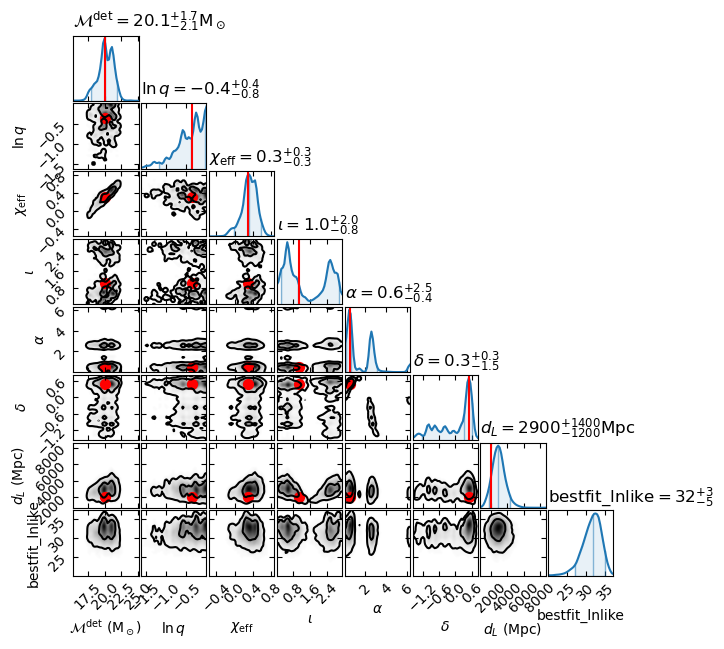

In [11]:
# Create corner plot with true injection parameters

# Compute true values for plotting
true_mchirp = gw_utils.m1m2_to_mchirp(injection_par_dic["m1"], injection_par_dic["m2"])
true_lnq = np.log(injection_par_dic["m2"] / injection_par_dic["m1"])
true_chieff = gw_utils.chieff(
    injection_par_dic["m1"],
    injection_par_dic["m2"],
    injection_par_dic["s1z"],
    injection_par_dic["s2z"],
)

true_values = injection_par_dic | {
    "mchirp": true_mchirp,
    "lnq": true_lnq,
    "chieff": true_chieff,
}

# Load standardized samples (created in previous cell)
samples = pd.read_feather(ARTIFACTS_DIR / "run_streamlined/run_3/samples.feather")

# Create corner plot

params = [
    "mchirp",
    "lnq",
    "chieff",
    "iota",
    "ra",
    "dec",
    "d_luminosity",
    "bestfit_lnlike",
]
corner_plot = gw_plotting.CornerPlot(
    samples,
    params=params,
    smooth=1.0,
)
corner_plot.plot(max_figsize=7)

# Add true injection parameters
corner_plot.scatter_points(
    true_values, colors="red", marker=".", s=200, label="Injection"
)

## Alternative: Using multiple banks


In [ ]:
# Create two banks
global_mass_range = (15, 30)
bank_names = ["bank_15_20", "bank_20_30"]
mass_ranges = [(15, 20), (20, 30)]
for i, (bank_name, mass_range) in enumerate(zip(bank_names, mass_ranges)):
    bank_dir = ARTIFACTS_DIR / bank_name
    bank_dir.mkdir(parents=True, exist_ok=True)

    bank_size = 2**15
    mchirp_min, mchirp_max = mass_range
    q_min = 0.2
    f_ref = 50.0
    seed = 888 + i
    n_pool = 4
    blocksize = 4096
    approximant = "IMRPhenomXPHM"

    # Generate bank samples
    powerlaw_prior = PowerLawIntrinsicIASPrior(
        mchirp_range=mass_range,
        q_min=q_min,
        f_ref=f_ref,
    )
    ias_prior = IntrinsicIASPrior(
        mchirp_range=global_mass_range,
        q_min=q_min,
        f_ref=f_ref,
    )
    pr_ratio = prior_ratio.PriorRatio(ias_prior, powerlaw_prior)
    # preemptive bugfix: sometimes not all matching items are removed
    prior_ratio._remove_matching_items(
        pr_ratio._numerator_subpriors, pr_ratio._denominator_subpriors
    )
    print(f"Generating {bank_size:,} bank samples...")
    bank_samples = powerlaw_prior.generate_random_samples(
        bank_size, seed=seed, return_lnz=False
    )

    # Compute derived quantities and weights
    bank_samples["mchirp"] = gw_utils.m1m2_to_mchirp(
        bank_samples["m1"], bank_samples["m2"]
    )
    bank_samples["lnq"] = np.log(bank_samples["m2"] / bank_samples["m1"])
    bank_samples["chieff"] = gw_utils.chieff(
        *bank_samples[["m1", "m2", "s1z", "s2z"]].values.T
    )
    mchirp_values = bank_samples["mchirp"].values
    bank_samples["log_prior_weights"] = bank_samples.apply(
        lambda row: pr_ratio.ln_prior_ratio(**row.to_dict()), axis=1
    )

    # Save bank
    bank_columns = [
        "m1",
        "m2",
        "s1z",
        "s1x_n",
        "s1y_n",
        "s2z",
        "s2x_n",
        "s2y_n",
        "iota",
        "log_prior_weights",
    ]
    samples_path = bank_dir / "intrinsic_sample_bank.feather"
    bank_samples[bank_columns].to_feather(samples_path)

    # Save bank config
    bank_config = {
        "bank_size": bank_size,
        "mchirp_min": mchirp_min,
        "mchirp_max": mchirp_max,
        "q_min": q_min,
        "f_ref": f_ref,
        "fbin": config.DEFAULT_FBIN.tolist(),
        "approximant": approximant,
        "m_arr": [2, 1, 3, 4],
        "seed": seed,
    }
    bank_config_path = bank_dir / "bank_config.json"
    with open(bank_config_path, "w") as f:
        json.dump(bank_config, f, indent=4)

    print(f"Saved bank to: {bank_dir}")
    print(f"Bank size: {len(bank_samples):,} samples")
    # Generate waveforms (this may take a few minutes)
    waveform_dir = bank_dir / "waveforms"
    print(f"Generating waveforms using {n_pool} cores...")
    waveform_banks.create_waveform_bank_from_samples(
        samples_path=samples_path,
        bank_config_path=bank_config_path,
        waveform_dir=waveform_dir,
        n_pool=n_pool,
        blocksize=blocksize,
        approximant=approximant,
    )
    print("Waveform generation complete!")

In [13]:
# Create a new rundir for streamlined run
streamlined_rundir = ARTIFACTS_DIR / "run_multibank"
streamlined_rundir.mkdir(parents=True, exist_ok=True)
n_int = 2**15
n_ext = 1024
n_phi = 50
blocksize = 2048
single_detector_blocksize = 2048
bank_names = ["bank_15_20", "bank_20_30"]

bank_folders = [ARTIFACTS_DIR / b for b in bank_names]
# Run streamlined inference
print("Running streamlined inference with inference.run()...")
final_rundir = inference.run_and_profile(
    event=event_data_path,
    bank_folder=bank_folders,
    n_int=n_int,
    n_ext=n_ext,
    n_phi=n_phi,
    n_t=n_t,
    blocksize=blocksize,
    single_detector_blocksize=single_detector_blocksize,
    seed=seed_ext,
    event_dir=str(streamlined_rundir),
    mchirp_guess=mchirp_guess,
    preselected_indices=None,
    max_incoherent_lnlike_drop=20,
    max_bestfit_lnlike_diff=20,
    draw_subset=True,
)

print("\nStreamlined inference complete!")
print(f"Results saved to: {final_rundir}")

# Load summary
summary_path = final_rundir / "summary_results.json"
summary = utils.read_json(summary_path)
print("\nSummary:")
print(f"  n_effective: {summary['n_effective']:.2f}")
print(f"  n_effective_i: {summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary['n_effective_e']:.2f}")
print(f"  ln_evidence: {summary['ln_evidence']:.2f}")

# Load final samples
final_samples = pd.read_feather(final_rundir / "samples.feather")
print(f"\nFinal samples shape: {final_samples.shape}")
print(f"Final samples saved to: {final_rundir / 'samples.feather'}")

Running streamlined inference with inference.run()...
Setting paths & loading configurations...
Creating COGWHEEL objects...
Searching incoherent solution for tutorial_inference_event
Set intrinsic parameters, lnL = 42.53277844115344
Set time, lnL(L) = 24.244898789800423
Set sky location, lnL = 36.595418537266205
Set phase and distance, lnL = 36.595418537266205
Set mchirp_range = (np.float64(12.707848419938214), np.float64(31.86284120637423))
Running inference with 2 bank(s)

=== Incoherent selection per bank ===

Processing bank: bank_0


Processing intrinsic batches: 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Bank bank_0: 32768 intrinsic samples evaluated.

Processing bank: bank_1


Processing intrinsic batches: 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


Bank bank_1: 32768 intrinsic samples evaluated.

=== Cross-bank threshold selection ===
Global maximum incoherent lnlike: 41.79
Global threshold: 21.79
Bank bank_0: 11305 intrinsic samples passed global threshold.
Bank bank_1: 7981 intrinsic samples passed global threshold.

=== Extrinsic sample generation ===
Generating extrinsic samples (global, multibank)...


2026-02-12 14:21:38 - Getting 16 MarginalizationInfo objects from 2 banks.
INFO:dot_pe.base_sampler_free_sampling_20260212-142138:Getting 16 MarginalizationInfo objects from 2 banks.
Marginalization objects: 100%|██████████| 16/16 [03:14<00:00, 12.14s/obj, batches=1/19, accepted=16/16] 
2026-02-12 14:24:54 - MarginalizationInfo object created!
INFO:dot_pe.base_sampler_free_sampling_20260212-142138:MarginalizationInfo object created!
2026-02-12 14:24:54 - Saving MarginalizationInfo object to artifacts/run_multibank/run_1.
INFO:dot_pe.base_sampler_free_sampling_20260212-142138:Saving MarginalizationInfo object to artifacts/run_multibank/run_1.



=== Coherent inference per bank ===

Processing bank: bank_0
Creating 6 x 1 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 6/6 [01:09<00:00, 11.66s/it]



Processing bank: bank_1
Creating 4 x 1 likelihood blocks...


Coherent likelihood blocks: 100%|██████████| 4/4 [01:00<00:00, 15.02s/it]



=== Combining results ===

Combining prob_samples across banks...
Standardizing samples...
Standardizing samples done in 0.589 seconds.
Saving samples to file...
Samples saved to:
 artifacts/run_multibank/run_1/samples.feather

Streamlined inference complete!
Results saved to: artifacts/run_multibank/run_1

Summary:
  n_effective: 7027.37
  n_effective_i: 97.87
  n_effective_e: 33.88
  ln_evidence: 3.00

Final samples shape: (3513, 50)
Final samples saved to: artifacts/run_multibank/run_1/samples.feather


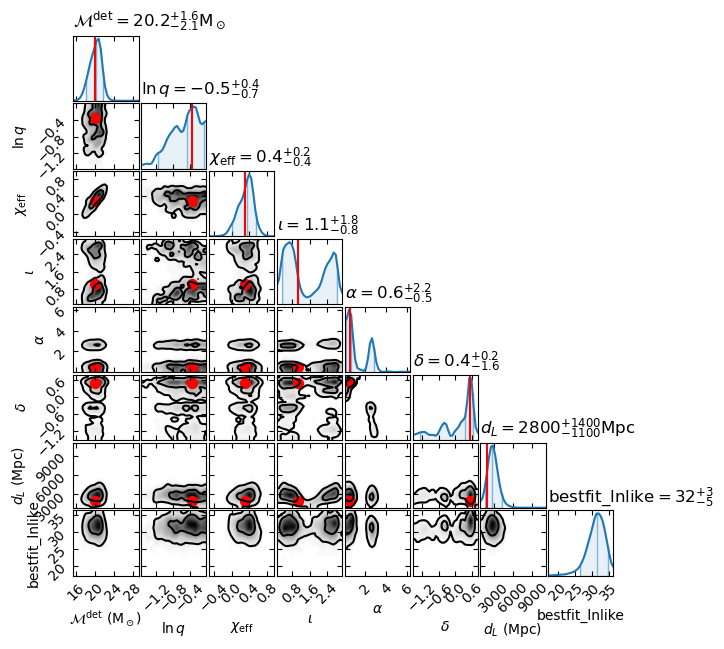

In [14]:
# Create corner plot with true injection parameters

# Compute true values for plotting
true_mchirp = gw_utils.m1m2_to_mchirp(injection_par_dic["m1"], injection_par_dic["m2"])
true_lnq = np.log(injection_par_dic["m2"] / injection_par_dic["m1"])
true_chieff = gw_utils.chieff(
    injection_par_dic["m1"],
    injection_par_dic["m2"],
    injection_par_dic["s1z"],
    injection_par_dic["s2z"],
)

true_values = injection_par_dic | {
    "mchirp": true_mchirp,
    "lnq": true_lnq,
    "chieff": true_chieff,
}

# Load standardized samples (created in previous cell)
samples = pd.read_feather(ARTIFACTS_DIR / "run_multibank/run_1/samples.feather")

# Create corner plot

params = [
    "mchirp",
    "lnq",
    "chieff",
    "iota",
    "ra",
    "dec",
    "d_luminosity",
    "bestfit_lnlike",
]
corner_plot = gw_plotting.CornerPlot(
    samples,
    params=params,
    smooth=1.0,
)
corner_plot.plot(max_figsize=7)

# Add true injection parameters
corner_plot.scatter_points(
    true_values, colors="red", marker=".", s=200, label="Injection"
)

# Compare Single- and Mulit-bank Results

In [ ]:
# Create corner plot with true injection parameters

# Compute true values for plotting
true_mchirp = gw_utils.m1m2_to_mchirp(injection_par_dic["m1"], injection_par_dic["m2"])
true_lnq = np.log(injection_par_dic["m2"] / injection_par_dic["m1"])
true_chieff = gw_utils.chieff(
    injection_par_dic["m1"],
    injection_par_dic["m2"],
    injection_par_dic["s1z"],
    injection_par_dic["s2z"],
)

true_values = injection_par_dic | {
    "mchirp": true_mchirp,
    "lnq": true_lnq,
    "chieff": true_chieff,
}

# Load standardized samples (created in previous cell)
multi = pd.read_feather(ARTIFACTS_DIR / "run_multibank/run_0/samples.feather")
single = pd.read_feather(ARTIFACTS_DIR / "run_streamlined/run_0/samples.feather")

# Create corner plot

params = [
    "mchirp",
    "lnq",
    "chieff",
    "iota",
    "ra",
    "dec",
    "d_luminosity",
    "bestfit_lnlike",
]
corner_plot = gw_plotting.MultiCornerPlot(
    [single, multi], params=params, smooth=1.0, labels=["Single bank", "Multi bank"]
)
corner_plot.plot(max_figsize=7)

# Add true injection parameters
corner_plot.scatter_points(
    true_values, colors="red", marker=".", s=200, label="Injection"
)

In [ ]:
single_summary_results = utils.read_json(
    "artifacts/run_streamlined/run_0/summary_results.json"
)
multi_summary_results = utils.read_json(
    "artifacts/run_multibank//run_0/summary_results.json"
)

In [ ]:
for k in single_summary_results.keys():
    print(k)
    if k in single_summary_results and k in multi_summary_results:
        print(f"single: {single_summary_results[k]}")
        print(f"multi: {multi_summary_results[k]}")